# Map Data

This project aligns readings from an ATV-based sampling system to a custom map grid and then aggregates the readings within those grid cells and subcells based on the assumptions below. The purpose of this aggregation is to generalize the reading levels across the geographic region.

* Input data is in a CSV file formatted y, x, reading
* Coordinates (y,x) are in local project format using US survey feet
* Map Tiles are named using two letters starting in the lower-left corner of the region as AA (first letter is vertical, second letter is horizontal)
* Each Tile is subdivided into 378 Survey Units (su) arranged 21 cells horizontally and 18 cells vertically
* The Survey Units are numbered 1 to 378 starting in the upper-left corner of the cell and proceeding left-to-right and top-to-bottom
* Each Survey Unit is 10m x 10m in size
* Each Survey Unit should be further divided into Subcells that are 1m x 1m
* For reference, the lower-left (South West) corner of Tile ZZ is (E): 2119489.0440 (N): 6790803.3130
* For reference, each Survey Unit is 32.81 ft x 32.81 ft
* The map area goes from ZZ to MK (16 horizontal Tiles X 14 vertical Tiles)


In [1]:
import logging
from PIL import Image, ImageDraw, ImageColor
from plotter import Plotter
logger = logging.getLogger()


# The calculations and grid plotting are now embedded in a Python class called Plotter
# You can control all kinds of settings, but most importantly the origin, bottom-left tile label, and tile label direction (ascending or descending)

# The CJ project has these settings
grid_settings={
    'origin':      (2119489.0440, 6790803.3130),
    'bottom_left': ('Z','Z'),
    'direction':   'descending'   
}

# We create a new Plotter object using these settings
cj = Plotter(**grid_settings)



## 1. Convert (x, y) to (Tile, SU, Subcell)
The convert_xy() function here is used to convert the given x and y coordinates to the correspoding Tile, Survey Unit, and Subcell. The origin, SU size, and grid dimensions are all customizable, but the values used in the Moab project are provided as examples here. These results are just for testing.

In [2]:
logger.setLevel(level=logging.DEBUG)

cj.convert_xy(2119489.0441, 6790803.3131)

DEBUG:root:2119489.0441, 6790803.3131 is 0.0 Tiles right and 0.0 Tiles up from the origin of ('Z', 'Z')
DEBUG:root:The origin of Tile ZZ is 2119489.044, 6790803.313
DEBUG:root:2119489.0441, 6790803.3131 is 0.0 SUs right and 0.0 Sus up from the origin of ZZ
DEBUG:root:The origin of SU ZZ-358 is 2119489.044, 6790803.313
DEBUG:root:2119489.0441, 6790803.3131 is 0.0 subcells right and 0.0 subcells up from the origin of ZZ-358


('ZZ', 358, 1)

In [3]:
cj.convert_xy(2119489.0441 + 32.81*22.01 + 4, 6790803.3131 + 32.81*19.01 + 4)

DEBUG:root:2120215.1922, 6791431.0312 is 1.0 Tiles right and 1.0 Tiles up from the origin of ('Z', 'Z')
DEBUG:root:The origin of Tile YY is 2120178.054, 6791393.893
DEBUG:root:2120215.1922, 6791431.0312 is 1.0 SUs right and 1.0 Sus up from the origin of YY
DEBUG:root:The origin of SU YY-338 is 2120210.864, 6791426.703
DEBUG:root:2120215.1922, 6791431.0312 is 1.0 subcells right and 1.0 subcells up from the origin of YY-338


('YY', 338, 12)

## 2. Read in a whole file of points with readings and convert those to grid locations
This section is where we read in an entire input file (using Pandas) and do our two different aggregation styles.
1. Arithmetic Mean in each Subcell -> Arithmetic Mean at the SU level
2. Arithmetic Mean of all the points in each SU

We also compute the difference between these aggregation styles to show how much error can be introduced. The "base" we compare against is #3 above, the "average of averages" calculation using arithmetic means.

In [4]:
# Use Pandas to read in the file and set the column headers since they aren't included
import pandas as pd

# Specify the file names and locations here
INPUT_FILE='SDG-001_Ra226_ScanData_YXReading.csv'
OUTPUT_FILE='SDG-001_Ra226_ScanData_YXReading.xlsx'

points = pd.read_csv(INPUT_FILE, dtype=float, header=None)
points.columns = ['Northing','Easting','Reading']
points.head()

,Northing,Easting,Reading
0,6666833.677,2187712.959,0.27809
1,6666833.668,2187712.959,0.33535
2,6666833.678,2187712.954,0.47949
3,6666833.672,2187712.957,1.10190
4,6666833.682,2187712.958,1.11176


In [ ]:
# Change the logging level so we don't get lots of noise from the convert_xy() function.
logger.setLevel(level=logging.INFO)

# Here, I switched back to the moab origin just for testing puposes.
# Uncomment this for testing purposes.

# moab_r_args = {
#     'origin':      (2180160.0001, 6660000.0000),
#     'bottom_left': ('Z','Z'),
#     'direction':   'descending'
# }
# cj = Plotter(**moab_r_args)

points[['Tile','SU','Subcell']] = points.apply(lambda v: cj.convert_xy(v[1], v[0]), axis=1, result_type='expand')
points.head()

/var/folders/kw/f8_98smd2ln6m2n6l89bs0xr0000gn/T/ipykernel_99499/3853444329.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  points[['Tile','SU','Subcell']] = points.apply(lambda v: cj.convert_xy(v[1], v[0]), axis=1, result_type='expand')


,Northing,Easting,Reading,Tile,SU,Subcell
0,6666833.677,2187712.959,0.27809,OP,168,23
1,6666833.668,2187712.959,0.33535,OP,168,23
2,6666833.678,2187712.954,0.47949,OP,168,23
3,6666833.672,2187712.957,1.10190,OP,168,23
4,6666833.682,2187712.958,1.11176,OP,168,23


## Do a multi-level aggregation of the readings within the grid locations

* Arithmetic Mean of the mean of all Subcells within an SU
* Arithmetic Mean of all the individual readings in an SU


In [6]:
# Compute the arithmetic and geometric means at the subcell level
from scipy.stats import gmean

subcell_mean = points.groupby(['Tile','SU','Subcell']).agg({'Reading': ['mean', 'count']}).reset_index()
subcell_mean.columns = ['Tile','SU','Subcell','Reading_mean', 'Reading_count']
subcell_mean

,Tile,SU,Subcell,Reading_mean,Reading_count
0,NO,211,4,0.512660,1
1,NO,211,6,0.676050,1
2,NO,211,7,0.842690,1
3,NO,211,9,0.745565,2
4,NO,211,10,0.760945,2
...,...,...,...,...,...
33684,OS,147,87,1.311110,1
33685,OS,147,90,1.307210,2
33686,OS,147,94,1.543850,1
33687,OS,147,96,2.185180,1


In [7]:
# Compute the arithmetic average of the subcell averages
su_subcell_mean = subcell_mean.groupby(['Tile','SU']).agg({'Reading_mean': ['mean', 'count'], 'Reading_count': 'sum'}).reset_index()
su_subcell_mean.columns = ['Tile','SU','Subcell_mean','Subcell_count','Reading_count']
su_subcell_mean

,Tile,SU,Subcell_mean,Subcell_count,Reading_count
0,NO,211,0.594555,42,48
1,NO,212,0.750035,18,21
2,NO,213,0.716376,27,38
3,NO,214,1.718211,36,42
4,NO,215,1.470896,39,48
...,...,...,...,...,...
814,OS,104,3.430701,13,107
815,OS,105,3.092665,46,61
816,OS,125,25.424101,10,14
817,OS,126,16.815088,43,110


In [8]:
# Compute the average in each cell based on all the points in that cell
su_mean = points.groupby(['Tile', 'SU']).agg({'Reading': ['mean', 'count']}).reset_index()
su_mean.columns = ['Tile','SU','Point_mean','Point_count']
su_mean.head()

,Tile,SU,Point_mean,Point_count
0,NO,211,0.605666,48
1,NO,212,0.740599,21
2,NO,213,0.726061,38
3,NO,214,1.719792,42
4,NO,215,1.433247,48


In [9]:
# Compute the percent difference between the subcell-based mean and the point-based mean
sus = pd.merge(su_subcell_mean, su_mean, how='outer', on=['Tile','SU'])
sus['Point_diff'] = (sus['Point_mean'] - sus['Subcell_mean']) / sus['Subcell_mean']
sus

,Tile,SU,Subcell_mean,Subcell_count,Reading_count,Point_mean,Point_count,Point_diff
0,NO,211,0.594555,42,48,0.605666,48,0.018689
1,NO,212,0.750035,18,21,0.740599,21,-0.012582
2,NO,213,0.716376,27,38,0.726061,38,0.013519
3,NO,214,1.718211,36,42,1.719792,42,0.000920
4,NO,215,1.470896,39,48,1.433247,48,-0.025596
...,...,...,...,...,...,...,...,...
814,OS,104,3.430701,13,107,1.696908,107,-0.505376
815,OS,105,3.092665,46,61,2.868267,61,-0.072558
816,OS,125,25.424101,10,14,24.996896,14,-0.016803
817,OS,126,16.815088,43,110,14.201458,110,-0.155434


In [10]:
# Create a glossary or table of contents page to include in the output Excel file
glossary = pd.DataFrame([
    ['Points', 'This sheet contains the raw data points with the Tile, SU, and Subcell location appended to each row'],
    ['Subcells', 'This sheet contains multiple aggregates at the Subcell level: arithmetic mean, count of readings'],
    ['SurveyUnits', 'This sheet contains multiple aggregates at the SU level: arithmetic mean of the subcell arithmetic means, arithmetic mean of all points in that SU, count of subcells with data, count of readings'],
])

In [11]:
# Write four sheets out to an Excel file
with pd.ExcelWriter(OUTPUT_FILE) as writer:
    glossary.to_excel(writer, sheet_name='Glossary', header=False)
    points.to_excel(writer, sheet_name='Points')
    subcell_mean.to_excel(writer, sheet_name='Subcells')
    sus.to_excel(writer, sheet_name='SurveyUnits')


<Axes: >

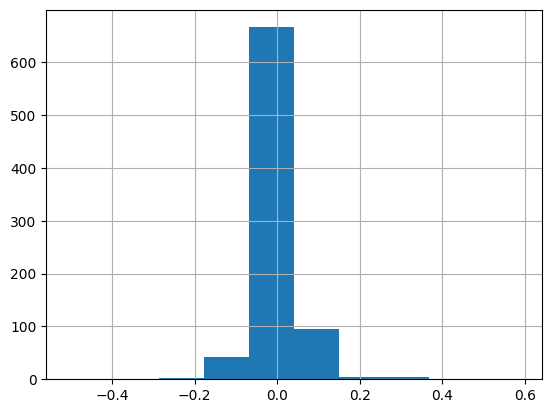

In [12]:
# For the sake of seeing the range and distribution of how much error is caused by
# not doing the average of averages method, we can include a histogram.

sus['Point_diff'].hist()

## 3. Plot a grid with points on it as a demonstration
To help us be sure we're calculating the grid locations correctly, I wrote a plotting function to draw out the grid and apply a color scheme to the SUs or Subcells we've computed values for.  This function is less well tested and documented, but you can see how it works below.

In [13]:
sus

,Tile,SU,Subcell_mean,Subcell_count,Reading_count,Point_mean,Point_count,Point_diff
0,NO,211,0.594555,42,48,0.605666,48,0.018689
1,NO,212,0.750035,18,21,0.740599,21,-0.012582
2,NO,213,0.716376,27,38,0.726061,38,0.013519
3,NO,214,1.718211,36,42,1.719792,42,0.000920
4,NO,215,1.470896,39,48,1.433247,48,-0.025596
...,...,...,...,...,...,...,...,...
814,OS,104,3.430701,13,107,1.696908,107,-0.505376
815,OS,105,3.092665,46,61,2.868267,61,-0.072558
816,OS,125,25.424101,10,14,24.996896,14,-0.016803
817,OS,126,16.815088,43,110,14.201458,110,-0.155434


## 4. Draw LH to ML with coloring

In [14]:
def color_map(x):
    if x < 5:
        return '#0000ff33'
    elif x < 7.4:
        return '#8800dd99'
    else:
        return '#ff0055bb'
    
sus['color'] = sus['Subcell_mean'].apply(color_map)
sus['location'] = sus['Tile'] + '-' + sus['SU'].astype(str)
sus

,Tile,SU,Subcell_mean,Subcell_count,Reading_count,Point_mean,Point_count,Point_diff,color,location
0,NO,211,0.594555,42,48,0.605666,48,0.018689,#0000ff33,NO-211
1,NO,212,0.750035,18,21,0.740599,21,-0.012582,#0000ff33,NO-212
2,NO,213,0.716376,27,38,0.726061,38,0.013519,#0000ff33,NO-213
3,NO,214,1.718211,36,42,1.719792,42,0.000920,#0000ff33,NO-214
4,NO,215,1.470896,39,48,1.433247,48,-0.025596,#0000ff33,NO-215
...,...,...,...,...,...,...,...,...,...,...
814,OS,104,3.430701,13,107,1.696908,107,-0.505376,#0000ff33,OS-104
815,OS,105,3.092665,46,61,2.868267,61,-0.072558,#0000ff33,OS-105
816,OS,125,25.424101,10,14,24.996896,14,-0.016803,#ff0055bb,OS-125
817,OS,126,16.815088,43,110,14.201458,110,-0.155434,#ff0055bb,OS-126


In [15]:
# Extract the shadings into a dictionary
shadings = sus[['location','color']].set_index('location').to_dict()['color']

INFO:root:Drawing Tile: NS at [0, 0, 2100, 1800]
INFO:root:Drawing Tile: OS at [0, 1800, 2100, 3600]
INFO:root:Drawing Tile: NR at [2100, 0, 4200, 1800]
INFO:root:Drawing Tile: OR at [2100, 1800, 4200, 3600]
INFO:root:Drawing Tile: NQ at [4200, 0, 6300, 1800]
INFO:root:Drawing Tile: OQ at [4200, 1800, 6300, 3600]
INFO:root:Drawing Tile: NP at [6300, 0, 8400, 1800]
INFO:root:Drawing Tile: OP at [6300, 1800, 8400, 3600]
INFO:root:Drawing Tile: NO at [8400, 0, 10500, 1800]
INFO:root:Drawing Tile: OO at [8400, 1800, 10500, 3600]


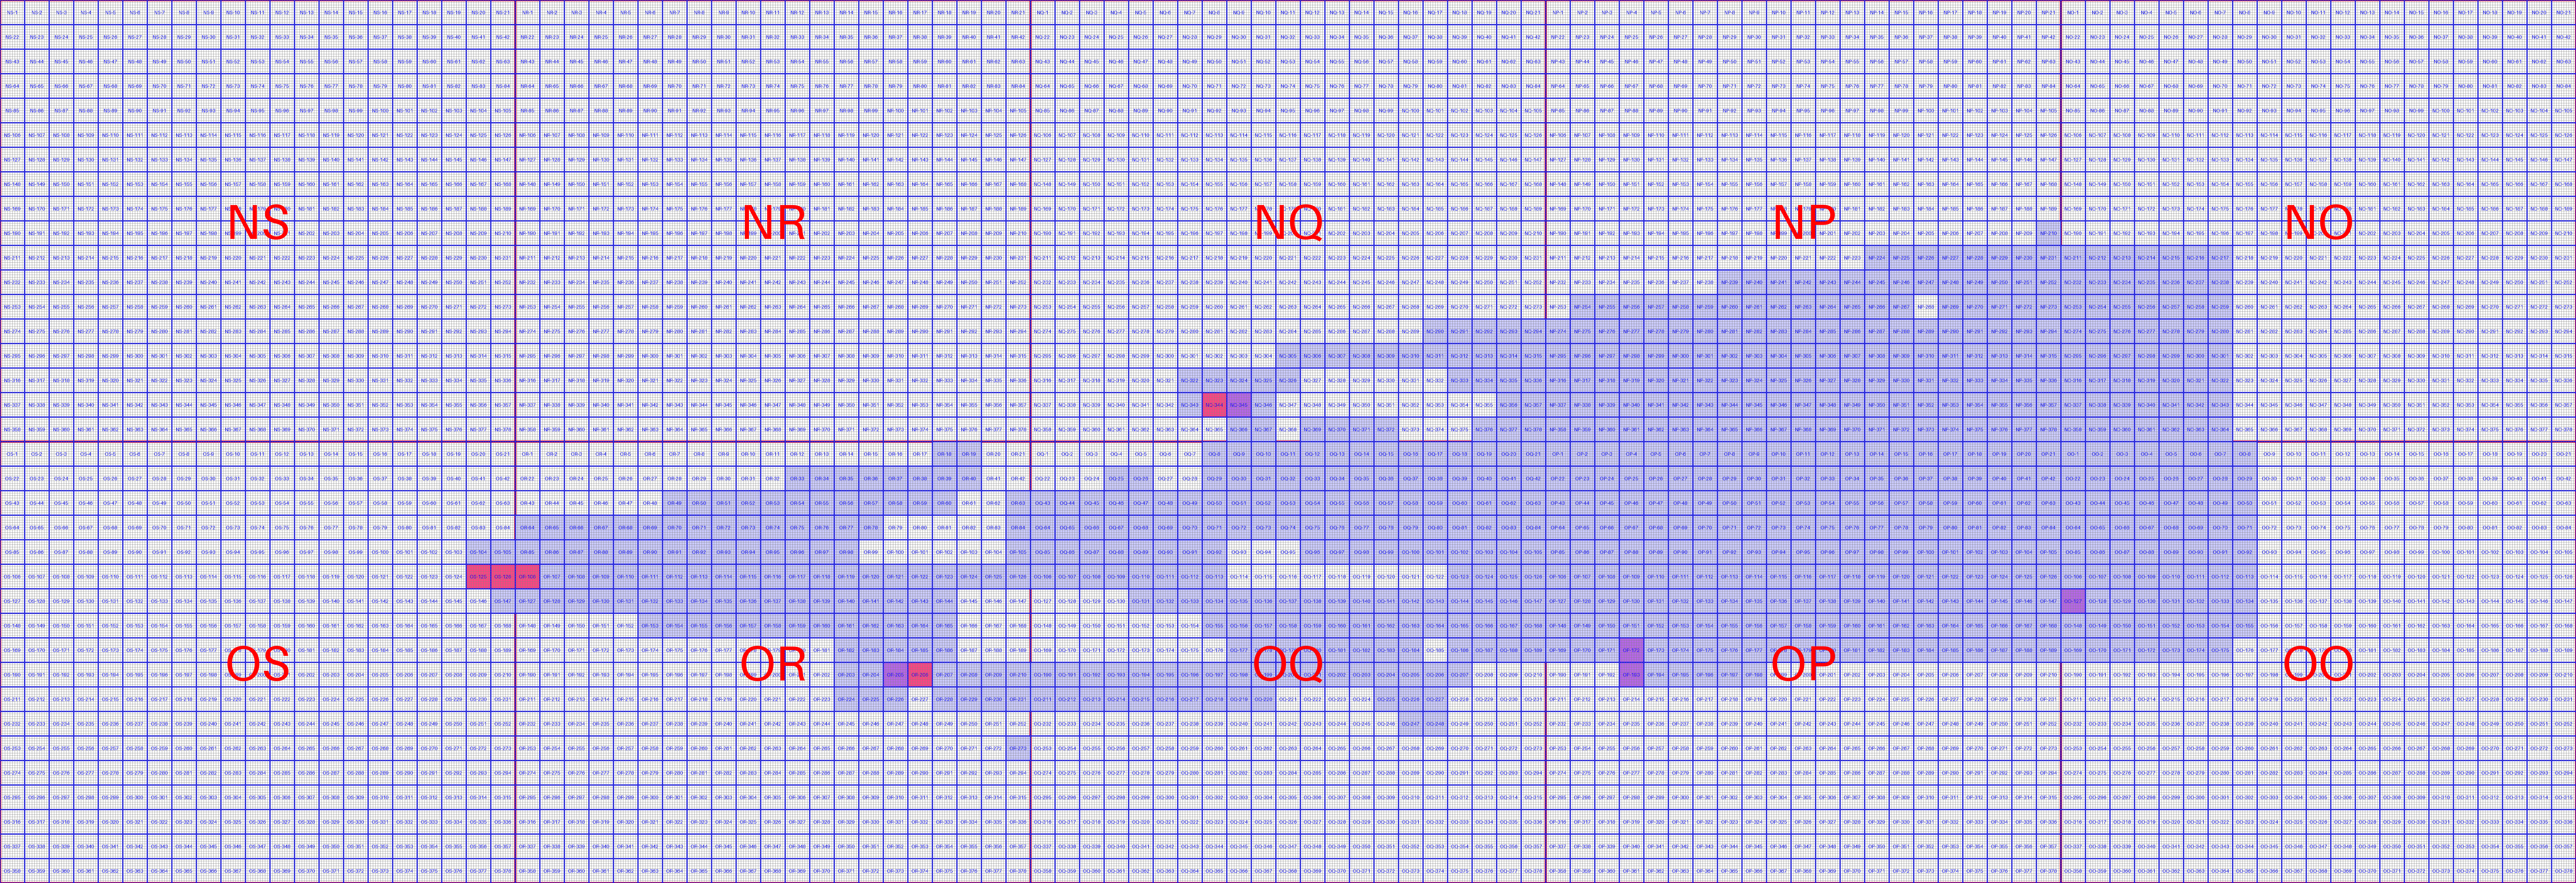

In [16]:
# Make sure we're not doing noisy debugging and create our image!
logger.setLevel(level=logging.INFO)

(img, grid) = cj.plot(
    shadings=shadings,
    base_su=(8,12),              # The SU we should start with in the bottom-left corner (L.H) -> (8,12)
    height_tiles=2, width_tiles=5,     # How many SUs to include in the visual
    subcell_size_px=10,          # How many pixels wide each subcell should be
    su_text=True,
    tile_text=True)
img